# Script for Estimating the fraction of explained Variance with bootstrapping

This script is doing the following:
- computing the explainable variance for a certain number of test image repeats
- bootstrapping this analysis by drawing random samples from image repeats 
- It requires to have a list or numpy array of "outputs", which are the responses of the neurons for each repeat of each test image. 
-- for example: np.array(n_images, n_repeats, n_neurons) or: 
-- list(np.array[n_repeats, n_neurons]_image1, np.array[n_repeats, n_neurons]_image2, ... )

# Imports

In [35]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Measure Functions

In [21]:
def compute_explainable_var(outputs, per_neuron=False, eps=1e-9):
    """
    Args:
        outputs (array or list): repeated responses/targets to the same input. with the shape [inputs, ] [reps, neurons]
                                    or array(inputs, reps, neurons)
        per_neuron (bool): returns the explainable variance either as average across all neurons, or as a 1d array the size of n_neurons.
    
    Returns: the fraction of explainable variance
    """
    
    ImgVariance = []
    TotalVar = np.var(np.vstack(outputs), axis=0, ddof=1)
    for out in outputs:
        ImgVariance.append(np.var(out, axis=0, ddof=1))
    ImgVariance = np.vstack(ImgVariance)
    NoiseVar = np.mean(ImgVariance, axis=0)
    explainable_var = (TotalVar - NoiseVar) / (TotalVar + eps)
    return explainable_var if per_neuron else np.mean(explainable_var)


def get_subset_of_repeats(outputs, repeat_limit=10, randomize=True):
    """
    Args:
        outputs (array or list): repeated responses/targets to the same input. with the shape [inputs, ] [reps, neurons]
                                    or array(inputs, reps, neurons)
        repeat_limit (int): how many reps are selected
        randomize (cool): if True, takes a random selection of repetitions. if false, takes the first n repetitions.

    Returns: limited_outputs (list): same shape as inputs, but with reduced number of repetitions
    """
    
    limited_output = []
    for repetitions in outputs:
        n_repeats = repetitions.shape[0]
        limited_output.append(repetitions[:repeat_limit, ] if not randomize else repetitions[
            np.random.choice(n_repeats, repeat_limit if repeat_limit < n_repeats else n_repeats, replace=False)])
    return limited_output

# Parameters for the analysis

In [58]:
# specifies the number of repeats that are tested, with increasing step size
n_repeats = np.hstack([np.arange(2,10), np.arange(10,20,2),  np.arange(20,40,4)])

# specifies how many samples are drawn for each test image.
# If the dataset is large, try 10 iterations. With more samples, the test gets more reliable. recommended: 30.
n_iters = 10

# Running the Analysis

the variable outputs has to exist here.

In [59]:
repeats, explainable_variance = [],[]

for i in range(n_iters):
    for reps in n_repeats:
        
        limited_outputs = get_subset_of_repeats(outputs, repeat_limit=reps)
        score = compute_explainable_var(limited_outputs, per_neuron=False)
        repeats.append(reps)
        explainable_variance.append(score)

In [60]:
df = pd.DataFrame({'repeats': repeats, 
                    'explainable variance': explainable_variance})

# Plotting

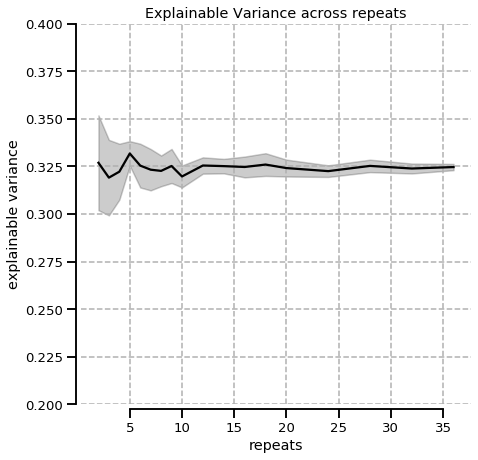

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.set_context('talk', font_scale=0.8)

plt.grid("on", ls='--')
sns.lineplot(x="repeats", y="explainable variance", data=df, ci="sd", color='k')

plt.title("Explainable Variance across repeats");
plt.ylim([0.20, 0.40])
sns.despine(trim=True, offset=5)
